<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#LyricsManager.py" data-toc-modified-id="LyricsManager.py-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LyricsManager.py</a></span></li><li><span><a href="#MoodyLyrics-issue" data-toc-modified-id="MoodyLyrics-issue-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>MoodyLyrics issue</a></span></li><li><span><a href="#New-features" data-toc-modified-id="New-features-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>New features</a></span><ul class="toc-item"><li><span><a href="#Dataset-Stats" data-toc-modified-id="Dataset-Stats-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Dataset Stats</a></span></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Feature Selection</a></span><ul class="toc-item"><li><span><a href="#Extra-test-set" data-toc-modified-id="Extra-test-set-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Extra test set</a></span></li></ul></li><li><span><a href="#Artificial-Neural-Network" data-toc-modified-id="Artificial-Neural-Network-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Artificial Neural Network</a></span></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#SVM" data-toc-modified-id="SVM-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>SVM</a></span></li><li><span><a href="#Gradient-Boost" data-toc-modified-id="Gradient-Boost-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Gradient Boost</a></span></li><li><span><a href="#Naive-Bayesian-Classifier" data-toc-modified-id="Naive-Bayesian-Classifier-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Naive Bayesian Classifier</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

In [76]:
import spacy
import os
import sys

import itertools

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from utils.datasets import load_dataset_from_path, split_train_validation

emotion_labels = ['happy', 'sad', 'angry', 'relaxed']

In [77]:
# Read extra test set
extra_test_path = './datasets/extra_test.csv'
extra_test = pd.read_csv(extra_test_path)

In [78]:
def plot_confusion_matrix(cm, classes = emotion_labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Introduction
**Previously on Sara&Mario project**: 
<ol>
    <li>*MoodyLyrics* stats analysis</li>
    <li>Lyrics classification using the main classifiers</li>
    <li>Emotion classification by just considering the song title</li> 
</ol>
Now, following the last meeting discussion we: 
<ol>
    <li>Wrote a script to create the dataset *SpotifyURI*, *List of PlaylistIDs*, *MoodyLyric_Emotion*</li>
    <li>Wrote a script to detect all duplicated songs in MoodyLyrics to fill a bug report</li>
    <li>Added new features for the classification task</li>
</ol>

# LyricsManager.py
After downloading the Spotify RecSys Challenge dataset we wrote a script that: <br>
<ul>
    <li>Given as input: the *Spotify playlist dataset folder*, and an output folder, creates a data structure to store for each song:<br>
        <*SpotifyURI*, *PlaylistIDs*, *TrackInformation*, *Emotion*><br>
        where: 
            <ul>
                <li>*SpotifyURI* is the songID</li>
                <li>*PlaylistsIDs* is the list of playlist in which the song appear</li>
                <li>*TrackInformation* is the list of information taken from Spotify dataset</li>
                <li>*Emotion* is an optional field, present only if the song is also contained in the MoodyLyrics dataset, that contains the emotion label for the song
    </li>
            </ul>
      <li>Can load Spotify songs datastructure (if already existing)</li>
            <li>Given as input a SpotifyURI it can download lyrics from lyricwikia</li>
</ul>

# MoodyLyrics issue
New week we detected duplicate information in MoodyLyrics. Now we can generate a .csv file capable of reporting those duplicates.

Now it's time to fill a bug.

# New features
Starting from MoodyLyrics we are going to create a new dataset with a lot of new features. <br>
<ul>
    <li>**Title_vector**</li>
    <li>**Lyric_vector**</li>
    <li>**%Rhymes**:<br> defined as the percentage of the number of rhymes over the number of total lines. A rhyme is defined as a rhyme between two following lines.</li>
    <li>**%Past_tense_verbs**:<br> defined as the the percentage of the number of past tense verbs over the total number of verbs.</li>
    <li>**%Present_tense_verbs**:<br>  defined as the the percentage of the number of present tense verbs over the total number of verbs.</li>
    <li>**%Future_tense_verbs**:<br>  defined as the the percentage of the number of future tense verbs over the total number of verbs, where future is just will + base form.</li>
    <li>**%ADJ**:<br> Percentage of adjectives over the total number of words.</li>
    <li>**%ADP**:<br> Percentage of adpositions (e.g. in, to, during) over the total number of words.</li>
    <li>**%ADV**:<br> Percentage of adverbs (e.g. very, tomorrow, down, where, there) over the total number of words.</li>
    <li>**%AUX**:<br> Percentage of auxiliaries (e.g. is, has (done), will (do), should (do)) over the total number of words.</li>
    <li>**%INTJ**:<br> Percentage of interjections (e.g. psst, ouch, bravo, hello) over the total number of words.</li>
    <li>**%NOUN**:<br> Percentage of nouns over the total number of words.</li>
    <li>**%NUM**:<br> Percentage of numerals over the total number of words.</li>
    <li>**%PRON**:<br> Percentage of pronouns (e.g. I, you, he, she, myself, themselves, somebody,...) over the total number of words.</li> 
    <li>**%PROPN**:<br> Percentage of proper nouns (e.g. Mary, John) over the total number of words.</li>
    <li>**%PUNCT**:<br> Percentage of puntuctuation (e.g. ., (, ), ?) over the total number of words.</li>
    <li>**%VERB**:<br> Percentage of verbs over the total number of words.</li>
    <li>**Selfish_degree**:<br> Percentage of 'I' pronouns over the total number of pronouns</li>
    <li>**%Echoism**:<br> Percentage of echoism over the total number of words, where an echoism is either a sequence of two subsequent repeated words or the repetition of a vowel in a word. </li>
    <li>**%Duplicates**:<br> Percentage of duplicate words over the total number of words</li>
    <li>**isTitleInLyric**:<br> Boolean, true if the title string is also a substring of the lyric</li>
    <li>**positive sentiment**:<br> Degree of positive sentiment expressed toward the argument</li>
    <li>**neutral sentiment**:<br> Degree of neutral sentiment expressed toward the argument</li>
    <li>**negative sentiment**:<br> Degree of negative sentiment expressed toward the argument</li>
</ul>

The sentiment analysis was done using the API available at this link [http://text-processing.com/](http://text-processing.com/). This API was trained on both twitter sentiment as well as movie reviews from the [data sets created by Bo Pang and Lillian Lee](http://www.cs.cornell.edu/people/pabo/movie-review-data/) using nltk-trainer

## Dataset Stats

In [79]:
import pandas as pd

In [80]:
dataset = pd.read_csv('./datasets/moodylyrics_featurized.csv')
"""
dataset.columns = ['ID', 'ARTIST', 'SONG_TITLE', 'LYRICS_VECTOR', 'TITLE_VECTOR', 
                   'LINE_COUNT', 'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
                   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'RHYMES', 'VERB_PRESENT', 
                   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES', 'CONJUCTION_FREQUENCIES', 
                   'ADV_FREQUENCIES', 'AUX_FREQUENCIES', 'CONJ_FREQUENCIES', 'CCONJ_FREQUENCIES', 
                   'DETERMINER_FREQUENCIES', 'INTERJECTION_FREQUENCIES', 'NOUN_FREQUENCIES', 
                   'NUM_FREQUENCIES', 'PART_FREQUENCIES', 'PRON_FREQUENCIES', 'PROPN_FREQUENCIES', 
                   'PUNCT_FREQUENCIES', 'SCONJ_FREQUENCIES', 'SYM_FREQUENCIES', 'VERB_FREQUENCIES', 
                   'X_FREQUENCIES', 'SPACE_FREQUENCIES', 
                   'SENTIMENT', 'SUBJECTIVITY',
                   'EMOTION']
"""                   

"\ndataset.columns = ['ID', 'ARTIST', 'SONG_TITLE', 'LYRICS_VECTOR', 'TITLE_VECTOR', \n                   'LINE_COUNT', 'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', \n                   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'RHYMES', 'VERB_PRESENT', \n                   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES', 'CONJUCTION_FREQUENCIES', \n                   'ADV_FREQUENCIES', 'AUX_FREQUENCIES', 'CONJ_FREQUENCIES', 'CCONJ_FREQUENCIES', \n                   'DETERMINER_FREQUENCIES', 'INTERJECTION_FREQUENCIES', 'NOUN_FREQUENCIES', \n                   'NUM_FREQUENCIES', 'PART_FREQUENCIES', 'PRON_FREQUENCIES', 'PROPN_FREQUENCIES', \n                   'PUNCT_FREQUENCIES', 'SCONJ_FREQUENCIES', 'SYM_FREQUENCIES', 'VERB_FREQUENCIES', \n                   'X_FREQUENCIES', 'SPACE_FREQUENCIES', \n                   'SENTIMENT', 'SUBJECTIVITY',\n                   'EMOTION']\n"

In [81]:
useless_columns = [ 'ID','ARTIST', 'SONG_TITLE', 'EMOTION', 'X_FREQUENCIES', 'SPACE_FREQUENCIES']

In [82]:
print(len(dataset.columns))

38


In [83]:
dataset.head(5)

,Unnamed: 0,ID,ARTIST,SONG_TITLE,LYRICS_VECTOR,TITLE_VECTOR,LINE_COUNT,WORD_COUNT,ECHOISMS,SELFISH_DEGREE,...,PROPN_FREQUENCIES,PUNCT_FREQUENCIES,SCONJ_FREQUENCIES,SYM_FREQUENCIES,VERB_FREQUENCIES,X_FREQUENCIES,SPACE_FREQUENCIES,SENTIMENT,SUBJECTIVITY,EMOTION
0,0,0,.38 Special,Fantasy Girl,[-2.59583928e-02 1.46213636e-01 -2.40031540e-...,[-0.1325517 0.07027499 -0.353215 0.047058...,35,174,0.0,0.291667,...,0.000000,0.051724,0.0,0.0,0.241379,0.0,0.0,0.137407,0.610000,relaxed
1,1,1,.38 Special,Second Chance,[-1.19381584e-02 2.30911389e-01 -1.93970740e-...,[-2.17199996e-02 3.36335003e-01 -1.79910004e-...,50,318,0.0,0.368421,...,0.000000,0.006289,0.0,0.0,0.345912,0.0,0.0,0.112576,0.310317,happy
2,2,2,22-20s,Hold On,[ 5.15404232e-02 1.07047103e-01 -2.46115208e-...,[-9.10529941e-02 1.45800002e-02 -2.31949985e-...,38,217,0.0,0.461538,...,0.000000,0.000000,0.0,0.0,0.313364,0.0,0.0,0.200000,0.400000,angry
3,3,3,3 Inches Of Blood,Trial Of Champions,[-7.87018538e-02 7.39747062e-02 -8.28025416e-...,[-3.40596698e-02 7.27466643e-02 2.60249972e-...,33,179,0.0,0.000000,...,0.011173,0.011173,0.0,0.0,0.245810,0.0,0.0,-0.015899,0.606838,angry
4,4,4,3 of Hearts,Is It Love,[-9.74312518e-03 2.82311559e-01 -1.53461650e-...,[ 1.86306313e-02 4.64353323e-01 -1.01861566e-...,45,252,0.0,0.223881,...,0.000000,0.166667,0.0,0.0,0.305556,0.0,0.0,0.479429,0.601429,happy


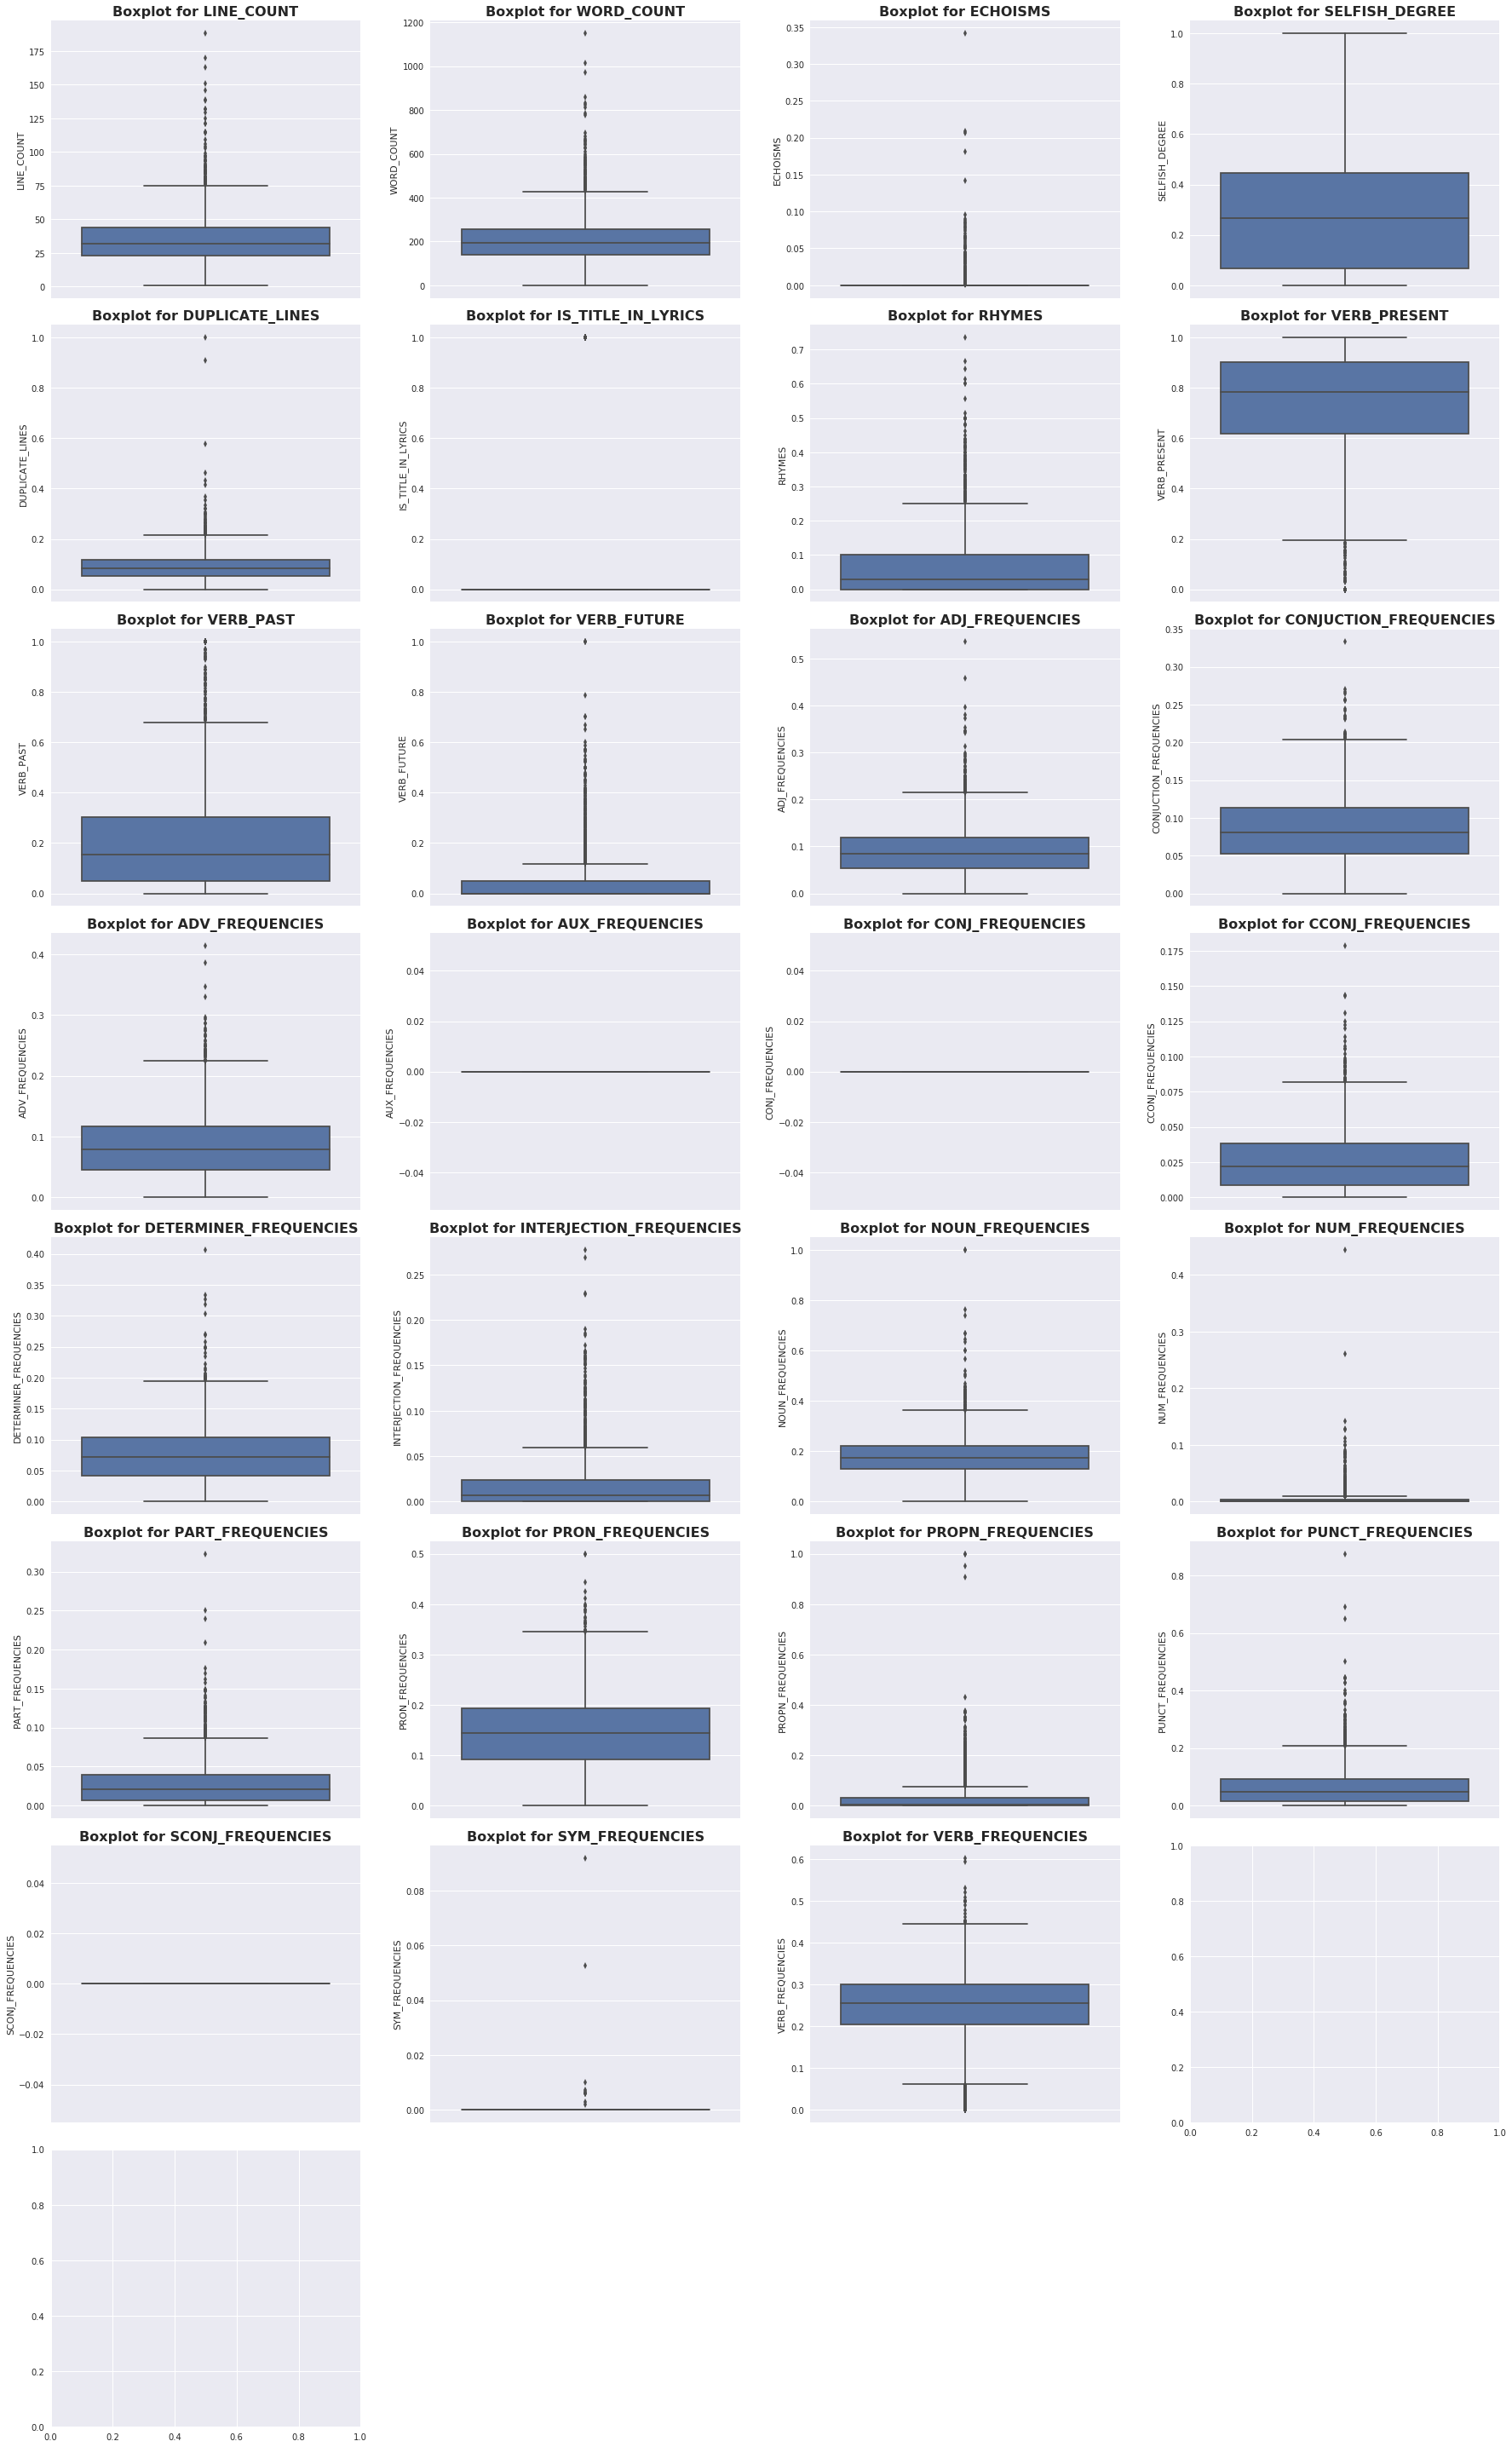

In [12]:
tmp_df = dataset.drop(useless_columns + ['LYRICS_VECTOR', 'TITLE_VECTOR'],axis=1)

f, axarr = plt.subplots(8, 4, figsize=(25,40))
k = 0
for feature in tmp_df.columns:
    (i, j) = divmod(k, 4)
    axarr[i,j] = sns.boxplot(y=tmp_df[feature], ax=axarr[i,j])
    axarr[i,j].set_title('Boxplot for {}'.format(feature), fontsize=16, weight='bold')
    k += 1
plt.tight_layout()
f.delaxes(axarr[-1,-1])
f.delaxes(axarr[-1,-2])
f.delaxes(axarr[-1,-3])

## Feature Selection

In [84]:
selected_columns = [
   'LYRICS_VECTOR',
   'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'VERB_PRESENT', 
   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
   'PUNCT_FREQUENCIES',
   'SENTIMENT', 'SUBJECTIVITY',
   'EMOTION'
]

In [85]:
dataset = dataset[selected_columns]
extra_test = extra_test[selected_columns]

In [86]:
tmp_df = dataset.drop(['EMOTION'], axis=1)
X_vect = list()
for (i, row) in tmp_df.iterrows():
    sub_list = list()
    for field in row:
        if type(field) == str:
            field = field[1:-1].split()
            sub_list += [float(x.replace('\n','')) for x in field]
        else:
            sub_list.append(field)
    X_vect.append(np.array(sub_list))
X_vect = np.array(X_vect)

In [87]:
y = dataset['EMOTION'].as_matrix().T

In [88]:
print(X_vect.shape)
print(y.shape)

(2452, 312)
(2452,)


In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size = 0.2, random_state = 0)

### Extra test set

In [90]:
tmp_df = extra_test.drop(['EMOTION'], axis=1)
X_test_extra = list()
for (i, row) in tmp_df.iterrows():
    sub_list = list()
    for field in row:
        if type(field) == str:
            field = field[1:-1].split()
            sub_list += [float(x.replace('\n','')) for x in field]
        else:
            sub_list.append(field)
    X_test_extra.append(np.array(sub_list))
X_test_extra = np.array(X_test_extra)

In [91]:
y_test_extra = extra_test['EMOTION'].as_matrix().T

## Artificial Neural Network

In [99]:
#2 y_nn should be a vector (len(X_vect),4), with a 1 in the right class
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_nn = np_utils.to_categorical(encoded_Y)

#3 Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# we need to scale because we don't want one feature to predomine the others
# Standardize features by removing the mean and scaling to unit variance
sc.fit(X_train)
X_train_nn = sc.transform(X_train)
X_test_nn = sc.transform(X_test)

In [100]:
#1 Importing the Keras libraries and packages
import keras
# Sequential module is required to initialize our ANN
from keras.models import Sequential
# Dense module is required to create the layers
from keras.layers import Dense, Dropout
    
def build_ann(optimizer='adam', input_size=X_vect.shape[1]):
    classifier = Sequential()
    #2 Adding first hidden layer
    classifier.add(Dense(units = 60, kernel_initializer = 'random_normal', activation = 'sigmoid', input_dim = input_size))
    classifier.add(Dropout(0.5))
    
    #2 Adding second hidden layer
    classifier.add(Dense(units = 60, kernel_initializer = 'random_normal', activation = 'sigmoid', input_dim = input_size))
    classifier.add(Dropout(0.5))
   

    # Adding output layer
    classifier.add(Dense(units = 4, kernel_initializer = 'random_normal', activation = 'softmax'))

    #3 Compiling the ANN
    classifier.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return classifier

In [65]:
from keras.wrappers.scikit_learn import KerasClassifier

keras_classifier = KerasClassifier(build_fn=build_ann)
parameters = {'batch_size': [256],
              'epochs': [100],
              'optimizer': ['adam']}
grid_search = GridSearchCV(estimator = keras_classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           verbose=False)
grid_search = grid_search.fit(X_train_nn, y_train_nn)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_
best_classifier = grid_search.best_estimator_
print('Accuracy: %0.2f' % (best_accuracy*100))
print('Best parameters', best_parameters)

Epoch 1/100
1764/1764 [==============================] - 1s 373us/step - loss: 1.3996 - acc: 0.2920
Epoch 2/100
1764/1764 [==============================] - 0s 24us/step - loss: 1.3971 - acc: 0.2732
Epoch 3/100
1764/1764 [==============================] - 0s 21us/step - loss: 1.3934 - acc: 0.2840
Epoch 4/100
1764/1764 [==============================] - 0s 22us/step - loss: 1.3879 - acc: 0.2863
Epoch 5/100
1764/1764 [==============================] - 0s 26us/step - loss: 1.3842 - acc: 0.2834
Epoch 6/100
1764/1764 [==============================] - 0s 26us/step - loss: 1.3853 - acc: 0.2783
Epoch 7/100
1764/1764 [==============================] - 0s 23us/step - loss: 1.3825 - acc: 0.2914
Epoch 8/100
1764/1764 [==============================] - 0s 25us/step - loss: 1.3836 - acc: 0.2834
Epoch 9/100
1764/1764 [==============================] - 0s 26us/step - loss: 1.3782 - acc: 0.3084
Epoch 10/100
1764/1764 [==============================] - 0s 24us/step - loss: 1.3806 - acc: 0.2902
Epoch 11

KeyboardInterrupt: 

Accuracy: 90.43


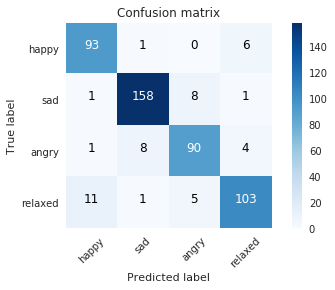

In [101]:
classifier = build_ann('adam')
classifier.fit(X_train_nn, y_nn, batch_size = 256, epochs = 100, verbose=0)
y_pred = classifier.predict(X_test_nn)

y_pred1 = np.argmax(y_pred,axis=1)

encoder = LabelEncoder()
encoder.fit(y_test)
encoded_Y = encoder.transform(y_test)
y_nn_pred = np_utils.to_categorical(encoded_Y)
cm = confusion_matrix(y_pred1, y_nn_pred.argmax(axis=1))
plot_confusion_matrix(cm)
accuracy = (sum([cm[i,i] for i in range(len(cm))])) / len(y_nn_pred)
print('Accuracy: %0.2f' % (accuracy*100))

Accuracy: 100.00


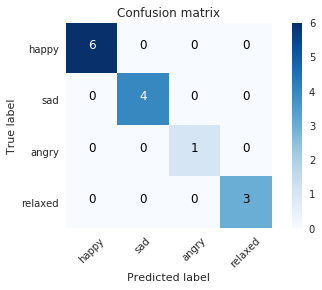

In [105]:
from sklearn.preprocessing import StandardScaler
X_test_extra_nn = sc.transform(X_test_extra)

y_pred_extra_nn = classifier.predict(X_test_extra_nn)

y_pred1 = np.argmax(y_pred_extra_nn, axis=1)

encoder = LabelEncoder()
encoder.fit(y_test)
encoded_Y = encoder.transform(y_test)
y_nn_pred = np_utils.to_categorical(encoded_Y)
cm = confusion_matrix(y_pred1, y_pred_extra_nn.argmax(axis=1))
plot_confusion_matrix(cm)
accuracy = (sum([cm[i,i] for i in range(len(cm))])) / len(y_pred_extra_nn)
print('Accuracy: %0.2f' % (accuracy*100))

## Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression
def evaluate_logreg(X_train, y_train, X_test, y_test):
    classifier = LogisticRegression(random_state=0)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, emotion_labels)
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.89


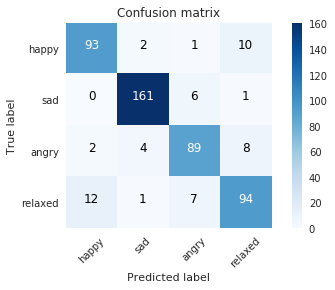

In [39]:
evaluate_logreg(X_train, y_train, X_test, y_test)

Accuracy of logistic regression classifier on test set: 0.64


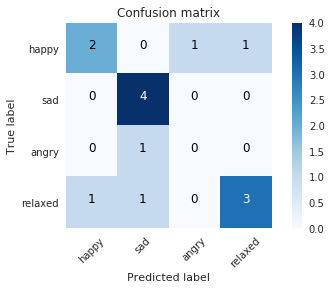

In [67]:
evaluate_logreg(X_train, y_train, X_test_extra, y_test_extra)

## SVM 

In [42]:
def parameters_grid_search(classifier, params, x, y, cv=10, verbose=False):
    """
    Grid Search to find best parameters for a certain classifier whose
    performances are evaluated using cross-validation
    """
    gs = GridSearchCV(classifier(), params, cv=cv, n_jobs=-1, verbose=verbose)
    gs.fit(x, y)    
    return (gs.best_estimator_, gs.best_params_)

In [43]:
from sklearn.svm import SVC

In [69]:
clf = SVC(C=10, kernel='rbf')
clf.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Accuracy of SVM classifier on test set: 0.47


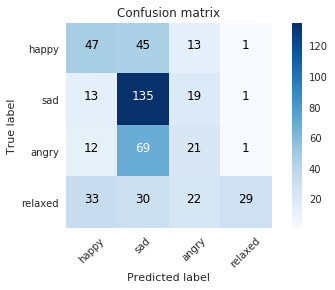

In [70]:
y_pred = clf.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
print('Accuracy of SVM classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of SVM classifier on extra test set: 0.50


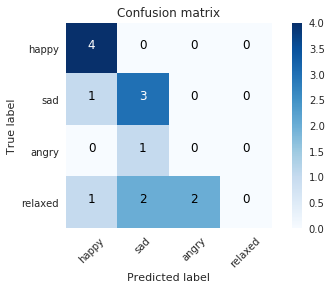

In [71]:
y_pred_extra = clf.predict(X_test_extra)
plot_confusion_matrix(confusion_matrix(y_test_extra, y_pred_extra))
print('Accuracy of SVM classifier on extra test set: {:.2f}'.format(clf.score(X_test_extra, y_test_extra)))

## Gradient Boost

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

# Build model
clf = GradientBoostingClassifier(learning_rate=0.7, n_estimators=200)
# Evaluate accuracy
scores = cross_val_score(clf, X_vect, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 1.96))

Accuracy: 0.83 (+/- 0.04)


In [193]:
clf = GradientBoostingClassifier(learning_rate=0.7, n_estimators=200)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

[[ 87   3   3  13]
 [  8 146  11   3]
 [  4  12  79   8]
 [ 20   5   5  84]]
Accuracy of SVM classifier on test set: 0.81


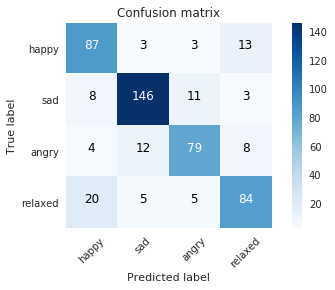

In [194]:
y_pred = clf.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
print('Accuracy of SVM classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

[[3 0 1 0]
 [1 2 0 1]
 [0 0 1 0]
 [3 1 1 0]]
Accuracy of Gradient Boosting classifier on extra test set: 0.43


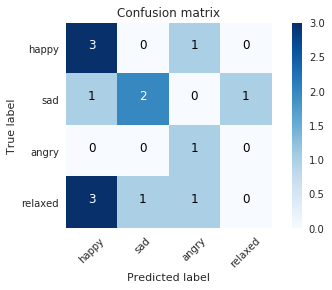

In [204]:
y_pred = clf.predict(X_test_extra)
plot_confusion_matrix(confusion_matrix(y_test_extra, y_pred))
print('Accuracy of Gradient Boosting classifier on extra test set: {:.2f}'.format(clf.score(X_test_extra, y_test_extra)))

## Naive Bayesian Classifier

In [72]:
from sklearn.naive_bayes import GaussianNB

In [73]:
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB(priors=None)

Accuracy of Naive-Bayes classifier on test set: 0.62


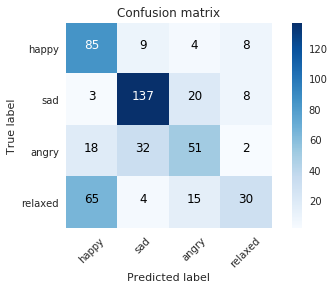

In [74]:
y_pred = clf.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
print('Accuracy of Naive-Bayes classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of Naive-Bayes classifier on extra test set: 0.43


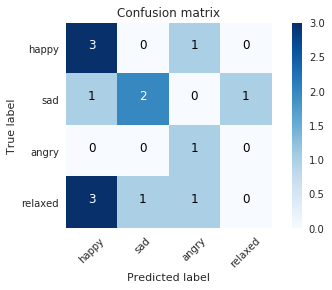

In [75]:
y_pred = clf.predict(X_test_extra)
plot_confusion_matrix(confusion_matrix(y_test_extra, y_pred))
print('Accuracy of Naive-Bayes classifier on extra test set: {:.2f}'.format(clf.score(X_test_extra, y_test_extra)))

# Conclusion
- The neural network is certainly the best classifier for our purpose
- We are always quite good at classifying sad songs but we often lack in performances while classifying other emotions